In [1]:
import numpy as np
np.set_printoptions(suppress=True)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.optimize import linprog
from autograd import grad
from scipy.stats import t, norm

In [2]:
class LADRegression:
    def __init__(self,X,y):
        if isinstance(X, pd.DataFrame):
            self.X = X.values
        elif isinstance(X, pd.Series):
            self.X = np.expand_dims(X.values, axis=1)
        else:
            if len(X.shape) != 2:
                raise ValueError('X should be a 2-d array')
            else:
                self.X = X
                
        if isinstance(y, pd.Series):
            self.y = y.values
        else:
            self.y = y
            
        self.method = None
        self.cost = None
        self.params = None
        self.std_error = None
        self.z = None
        self.interval = None
        self.residual = None
        self.p_val = None
        
        
    def get_index_positive(self, x):
        for i in range(len(x)):
            if x[i] > 0:
                return i-1
        return False
    
    
    def fit(self, round_digit=5, alpha=0.01, max_its=100, initial_params=None, tolerance=1e-5, epsilon=1e-2, method='data_points',
           threshold_num_data=20, significance_level=0.5):
        self.method = method
        if method == 'data_points':
            self._fit_data_points(round_digit)
        elif method == 'subgradient':
            self._fit_subgradient(alpha, max_its, initial_params, tolerance)
        elif method == 'irls':
            self._fit_irls(initial_params, max_its, epsilon, tolerance)
        elif method == 'lp':
            self._fit_lp()
        else:
            methods = ['data_points', 'subgradient', 'irls', 'lp']
            raise ValueError(f'method should be one of {methods}')
            
        if self.params is not None:
            self._get_residual()
            self._get_std_error()
            self._get_interval(threshold_num_data, significance_level)
            self._get_z()
            self._get_p_val(threshold_num_data)
            
            
    def _single_fit(self, X,y):
        x = X[:,X.shape[1]-1]
        mean_x = np.mean(x)
        
        #Step1 Find index which has the closest distance to mean
        distances = np.linalg.norm(x-mean_x)
        idx = np.where(distances == np.min(distances))[0][0]
        
        starting_x = X[idx, X.shape[1]-1]
        starting_y = y[idx]
        
        #Step2
        xyslopes = []
        
        for i in range(len(y)):
            if starting_x == x[i]:
                continue
            slope = (y[i] - starting_y)/(x[i] - starting_x)
            xyslopes.append((x[i],y[i], slope))
            
        sorted_xyslopes = sorted(xyslopes, key = lambda x:x[2])
        valid_x_set = [x[0] for x in sorted_xyslopes]
        W = np.sum(abs(valid_x_set - starting_x))
        
        W_zeros = np.array([2*np.sum(abs(valid_x_set[:i+1]-starting_x)) for i in range(len(valid_x_set))])
        W_diff = W_zeros - W
        
        if (W_diff > 0).all():
            target_x = sorted_xyslopes[0][0]
            target_y = sorted_xyslopes[0][1]
        else:
            v_0 = self.get_index_positive(W_diff)
            
            if W_diff[v_0] <= 0:
                target_x = sorted_xyslopes[v_0 + 1][0]
                target_y = sorted_xyslopes[v_0 + 1][1]
            else:
                raise ValueError('Something impossible happens')
                
        slope1 = (target_y - starting_y)/(target_x - starting_x)
        
        if X.shape[1] == 2:
            intercept1 = -slope1*starting_x + starting_y
            params = np.array([intercept1, slope1])
        elif X.shpae[1] == 1:
            params = np.array([slope1])
            
        G1 = np.sum(abs(y - X.dot(params)))
        starting_x = target_x
        starting_y = target_y
        
        #Step 3
        while True:
            xyslopes = []
            
            for i in range(len(y)):
                if starting_x == x[i]:
                    continue
                slope = (y[i]-starting_y)/(x[i]-starting_x)
                xyslopes.append((x[i],y[i], slope))

            sorted_xyslopes = sorted(xyslopes, key = lambda x:x[2])
            valid_x_set = [x[0] for x in sorted_xyslopes]
            W = np.sum(abs(valid_x_set-starting_x))

            W_zeros = np.array([2*np.sum(abs(valid_x_set[:i+1]-starting_x)) for i in range(len(valid_x_set))])
            W_diff = W_zeros - W

            if (W_diff > 0).all():
                target_x = sorted_xyslopes[0][0]
                target_y = sorted_xyslopes[0][1]
            else:
                v_0 = self.get_index_positive(W_diff)
                
                if W_diff[v_0] <= 0:
                    target_x = sorted_xyslopes[v_0 + 1][0]
                    target_y = sorted_xyslopes[v_0 + 1][1]
                else:
                    raise ValueError('Something impossible happens')

            slope1 = (target_y-starting_y)/(target_x-starting_x)

            if X.shape[1] == 2:
                intercept1 = -slope1*starting_x + starting_y
                params = np.array([intercept1, slope1])
            elif X.shpae[1] == 1:
                params = np.array([slope1])
                
            G2 = np.sum(abs(y-X.dot(params)))
            
            if G2 < G1:
                G1 = G2
                starting_x = target_x
                starting_y = target_y
            else:
                return params
                break
            
            
            
    def _fit_data_points(self, round_digit):
        if self.X.shape[1] == 2 :
            self.params = self._single_fit(self.X, self.y)
            self.cost = self._cost(self.params)
        elif self.X.shape[1] == 1:
            raise ValueError('the number of cilumns should be greater than 1')
        else:
            p = self.X.shape[1]
            mean_x = np.mean(self.X, axis=0)

            #Step1 Find index whioch has the closest distance to mean
            distances = np.linalg.norm(self.X-mean_x, axis=1)
            idx = np.argpartition(distances, p)
            idx = idx[:p]

            #Step2 Find best stepsize and direction
            A = self.X[idx]
            c = self.y[idx]

            while True:
                A_inv = np.linalg.inv(A)
                b = A_inv.dot(c)
                res = []

                for j in range(A_inv.shape[1]):
                    d = A_inv[:,j]
                    W_minus = 0
                    W_zero = 0
                    W_plus = 0

                    for i in range(self.X.shape[0]):
                        z = self.y[i] - b.dot(self.X[i])
                        w = d.dot(self.X[i])
                        w = round(w, round_digit)

                        if w==0:
                            pass
                        else:
                            if z/w < 0 :
                                W_minus += abs(w)
                            elif round(z, round_digit) == 0:
                                W_zero += abs(w)
                            elif z/w > 0:
                                W_plus += abs(w)

                    derivative_val = W_minus + W_zero - W_plus
                    res.append((j,d,derivative_val))

                for j in range(A_inv.shape[1]):
                    d = - A_inv[:,j]
                    W_minus = 0
                    W_zero = 0
                    W_plus = 0

                    for i in range(self.X.shape[0]):
                        z = self.y[i] - b.dot(self.X[i])
                        w = d.dot(self.X[i])
                        w = round(w, round_digit)

                        if w==0:
                            pass
                        else:
                            if z/w < 0 :
                                W_minus += abs(w)
                            elif round(z, round_digit) == 0:
                                W_zero += abs(w)
                            elif z/w > 0:
                                W_plus += abs(w)

                    derivative_val = W_minus + W_zero - W_plus
                    res.append((j,d,derivative_val))

                derivative_vals = np.array([x[2] for x in res])

                if min(derivative_vals) >= 0:
                    self.params = b
                    self.cost = self._cost(self.params)
                    break
                else:
                    sorted_res = sorted(res, key=lambda x: x[2])
                    col_idx, col_vec, _ = sorted_res[0]
                    z = self.y - self.X.dot(b)
                    z = np.array([round(x, round_digit) for x in z])
                    w = self.X.dot(col_vec)
                    w = np.array([round(x, round_digit) for x in w])
                    T = np.sum(abs(w))
                    zwslopes = []

                    for i in range(len(z)):
                        if w[i] == 0 :
                            pass
                        else:
                            slope = z[i] / w[i]
                            zwslopes.append((i, z[i],w[i], slope))

                    sorted_zwslopes = sorted(zwslopes, key = lambda x:x[3])

                    valid_w = [s[2] for s in sorted_zwslopes]
                    valid_w = np.array(valid_w)

                    T_zeros = np.array([2*np.sum(abs(valid_w[:i+1])) for i in range(len(valid_w))])
                    T_diff = T_zeros - T

                    if (T_diff > 0).all():
                        w_idx = 0
                    else:
                        v_0 = self.get_index_positive(T_diff)

                        if T_diff[v_0] <= 0:
                            w_idx = v_0 +1
                        else:
                            raise ValueError('Something impossible happens')

                    w_val = valid_w[w_idx]
                    new_idx = [s for s in sorted_zwslopes if s[2]==w_val][0][0]
                    A[col_idx] = self.X[new_idx]
                    c[col_idx] = self.y[new_idx]
                        
                        
    def _fit_subgradient(self, alpha, max_its, initial_params, tolerance):
        if initial_params is None:
            X_tX = self.X.T.dot(self.X)
            X_tX_inv = np.linalg.inv(X_tX)
            w = X_tX_inv.dot(X.T.dot(self.y))
        else:
            w = initial_params
            
        gradient = grad(self._cost)
        its = 0
        ws = [w]
        cost_vals = [self._cost(w)]
        
        while its < max_its:
            its += 1
            
            grad_eval = gradient(w)
            w = w - alpha*grad_eval
            cost_val = self._cost(w)
            ws.append(w)
            cost_vals.append(cost_val)
            
        min_cost = min(cost_vals)
        min_idx = cost_vals.index(min_cost)
        
        self.params = ws[min_idx]
        self.cost = min_cost
        
        
    def  _fit_irls(self, initial_params, max_its, epsilon, tolerance):
        if initial_params is None:
            X_tX = self.X.T.dot(self.X)
            X_tX_inv = np.linalg.inv(X_tX)
            w = X_tX_inv.dot(X.T.dot(self.y))
        else:
            w = initial_params
            
        train_X = self.X
        train_y =self.y
        
        its = 0
        while its < max_its:
            residual = train_y - train_X.dot(w)
            weight = 1/np.sqrt(np.square(residual)+epsilon)
            W = np.diag(weight)
            
            X_tWX = train_X.T.dot(W.dot(train_X))
            X_tWX_inv = np.linalg.inv(X_tWX)
            new_w = X_tWX_inv.dot(train_X.T.dot(W.dot(train_y)))
            
            if np.linalg.norm(new_w-w) < tolerance:
                break
            else:
                w = new_w
                
        self.params = np.squeeze(new_w)
        self.cost = self._cost(self.params)
        
    
    def _fit_lp(self):
        b = self.y
        A = self.X

        c = -np.sum(A, axis=0)
        c = np.hstack((c,2*np.ones(len(b))))
        
        epsilon_bounds = []
        
        for i in range(A.shape[1]):
            epsilon_bounds.append((None, None))
            
        for i in range(len(b)):
            epsilon = np.zeros(len(b))
            epsilon[i] = -1
            
            if i == 0:
                temp = epsilon
            else:
                temp = np.vstack((temp, epsilon))
            epsilon_bounds.append((0, None))
            
        A = np.hstack((A, temp))
        res = linprog(c, A_ub = A, b_ub = b, bounds = epsilon_bounds)
        self.params =res.x[:self.X.shape[1]]
        self.cost = self._cost(self.params)
        
    def predict(self,X):
        prediction = [self._predict(x) for x in X]
        return prediction
    
    
    def _predict(self,x):
        return x.dot(self.params)
    
    
    def _cost(self,w):
        cost = np.sum(np.abs(self.y - self.X.dot(w)))
        return cost
    
    
    def _get_interval(self, threshold_num_data, significance_level):
        X = self.X
        y = self.y
        params = self.params
        std_error = self.std_error
        dof = len(y) - X.shape[1]
        alpha = 0.5
        
        if X.shape[0] < threshold_num_data:
            coef = t.ppf(1 - alpha/2, dof)
        else:
            coef = norm.ppf(1- alpha/2)
            
        cis = []
        
        for i, p in enumerate(self.params):
            ub = p + coef*std_error[i]
            lb = p - coef*std_error[i]
            ci = (lb,ub)
            cis.append(ci)
            
        self.interval = cis
        
        
    def _get_std_error(self):
        X = self.X
        y = self.y
        dof = len(y) - X.shape[1]
        
        assert dof > 0, 'the degree of freedom must be positive'
        round_digit = 5
        X_tX_inv = np.linalg.inv(X.T.dot(X))
        residual = self.residual
        residual = [round(r, round_digit) for r in residual]
        
        num_zero = X.shape[1]
        
        for r in residual:
            if num_zero == 0 :
                break
            if r == 0:
                residual.remove((r))
                num_zero -= 1
                
        residual = sorted(residual)
        k1 = int(round((dof + 1)/2 - np.sqrt(dof)))
        k2 = int(round((dof + 1)/2 + np.sqrt(dof)))
        
        tau = np.sqrt(dof)*(residual[k2] - residual[k1])/4
        std_error = np.sqrt(np.diagonal(tau * X_tX_inv))
        self.std_error = std_error
        
        
    def _get_z(self):
        self.z = self.params/self.std_error
        
        
    def _get_residual(self):
        self.residual = self.y - self.X.dot(self.params)
        
        
    def _get_p_val(self, threshold_num_data):
        X = self.X
        y = self.y
        z = self.z
        std_error =  self.std_error
        dof = len(y) - X.shape[1]
        alpha = 0.5
        t_dis = False
        
        if X.shape[0] < threshold_num_data:
            t_dis = True
        if t_dis:
            self.p_val = 2*(1 - t.cdf(abs(z), dof))
        else:
            self.p_val = 2*(1 - norm.cdf(abs(z)))
            
            
    def summary(self, prefix='x'):
        X = self.X
        params = self.params
        std = self.std_error
        z = self.z
        interval = self.interval
        p_val = self.p_val
        
        method = self.method
        if method == 'lp':
            method = 'linear programming'
        if method == 'irls':
            method = 'iterative reweighted least square'
        print(f'{method} method used')
        
        texts = ['coef.', 'est.', 'std', 'z', 'lower', 'upper', 'P(Z>|z|)']
        string = ''
        
        for t  in texts:
            string += f'{t:<8}'
        print(string)
        
        f = lambda x:str(round(x,4))
        
        prefix = 'x' 
        
        for i in range(X.shape[1]):
            string = ''
            texts = [prefix + str(i), f(params[i]), f(std[i]), f(z[i]), f(interval[i][0]), f(interval[i][1]), f(p_val[i])]
            
            for t in texts:
                string += f'{t:<8}'
            print(string)

### 모의실험

In [3]:
np.random.seed(101)

n = 19
p = 1
epsilon = np.random.randn(n)
true_beta = np.array([1,2])
X = np.squeeze(np.random.rand(n,p))
const = np.ones(n)
const = np.expand_dims(const, axis=1)
X = np.hstack((const, np.expand_dims(X, axis=1)))
y = X.dot(true_beta) + epsilon

In [4]:
methods = ['data_points', 'subgradient', 'irls', 'lp', 'ols']
max_str = max([len(x) for x in methods])
print('%-*s%-*s%-*s'%(max_str+3, 'method', 25, 'estimates', 8, 'cost'))

for m in methods:
    lar = LADRegression(X,y)
    
    if  m == 'subgradient':
        lar.fit(method= m, initial_params = np.array([2.0,1.5]))
        params = lar.params
        cost = lar.cost
    elif m == 'ols':
        X_tX_inv = np.linalg.inv(X.T.dot(X))
        params = X_tX_inv.dot(X.T.dot(y))
        cost = np.sum(np.abs(y - X.dot(params)))
    else:
        lar.fit(method=m)
        params = lar.params
        cost = lar.cost
    print('%-*s%-*s%-*s'%(max_str+3, m, 25, str(params), 8, str(round(cost,4))))

method        estimates                cost    
data_points   [1.11562631 2.75215285]  15.8913 
subgradient   [1.45       2.14477488]  16.2717 
irls          [1.16646927 2.64308899]  15.9688 
lp            [1.11562631 2.75215285]  15.8913 
ols           [1.52868131 1.7912233 ]  16.8968 


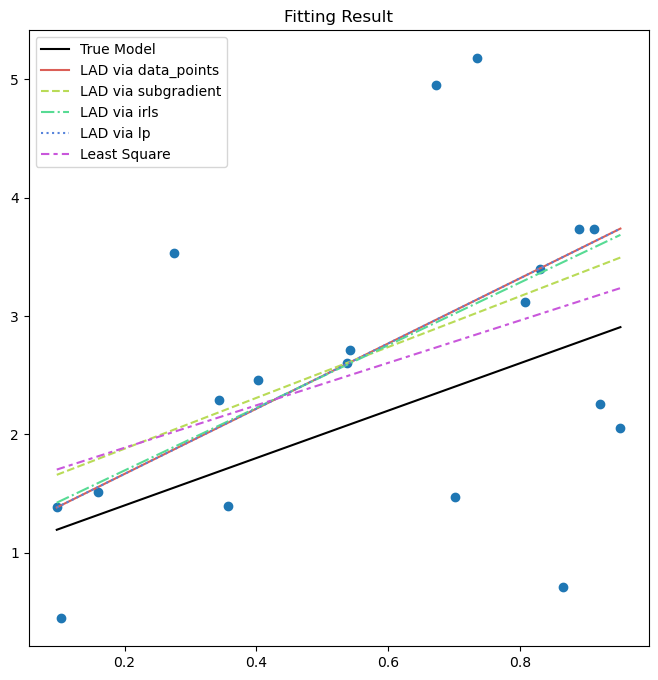

In [5]:
#visualize

x = np.linspace(min(X[:,1]), max(X[:,1]))
x = np.hstack((np.expand_dims(np.ones(len(x)), axis=1), np.expand_dims(x, axis=1)))

fig = plt.figure(figsize = (8,8))
fig.set_facecolor('white')

plt.scatter(X[:,1],y)
plt.plot(x[:,1], x.dot(true_beta), label = 'True Model', color = 'k')

methods = ['data_points', 'subgradient', 'irls', 'lp', 'ols']
line_type = ['-', '--', '-.', ':', (0,(4,2,2,2))]
colors = sns.color_palette('hls', len(methods))

for i,m in enumerate(methods):
    lar = LADRegression(X,y)
    label = f'LAD via {m}'
    if  m == 'subgradient':
        lar.fit(method= m, initial_params = np.array([2.0,1.5]))
        params = lar.params
    elif m == 'ols':
        X_tX_inv = np.linalg.inv(X.T.dot(X))
        params = X_tX_inv.dot(X.T.dot(y))
        label = 'Least Square'
    else:
        lar.fit(method=m)
        params = lar.params

    plt.plot(x[:,1], x.dot(params), label = label, color = colors[i], linestyle = line_type[i])
    
plt.title('Fitting Result')
plt.legend()

###  실제 데이터

In [6]:
df = pd.read_csv('./data/chicago_information_reduced.csv')

In [7]:
df.head()

,area,fire,log_fire,theft,age,income
0,1,6.2,1.824549,29,0.604,11.744
1,2,9.5,2.251292,44,0.765,9.323
2,3,10.5,2.351375,36,0.735,9.948
3,4,7.7,2.041220,37,0.669,10.656
4,5,8.6,2.151762,53,0.814,9.730


In [8]:
X = df[['age', 'theft', 'income']]
y = df['log_fire'].map(lambda x: round(x, 3))
X = sm.add_constant(X)
X = X.values

initial_params = None
methods = ['data_points', 'subgradient', 'irls', 'lp', 'ols']
max_str = max([len(x) for x in methods])
print('%-*s%-*s%-*s'%(max_str+3, 'method', 25, 'estimates', 8, 'cost'))

for m in methods:
    lar = LADRegression(X,y)
    
    if  m == 'subgradient':
        lar.fit(method= m, initial_params = initial_params)
        params = lar.params
        cost = lar.cost
    elif m == 'ols':
        X_tX_inv = np.linalg.inv(X.T.dot(X))
        params = X_tX_inv.dot(X.T.dot(y))
        cost = np.sum(np.abs(y - X.dot(params)))
    else:
        lar.fit(method=m)
        params = lar.params
        cost = lar.cost
    print('%-*s%-*s%-*s'%(max_str+3, m, 25, str(params), 8, str(round(cost,4))))

method        estimates                cost    
data_points   [ 4.36213663 -0.09097895  0.01298985 -0.24253319]15.784  
subgradient   [ 4.10232063  0.26891586  0.00989279 -0.22323989]16.1759 
irls          [ 4.30081911 -0.0048791   0.01378512 -0.24094921]15.9307 
lp            [ 4.36213663 -0.09097895  0.01298985 -0.24253319]15.784  
ols           [ 4.10232063  0.26891586  0.00989279 -0.22323989]16.1759 


In [9]:
lar = LADRegression(X,y)
lar.fit()
lar.summary()

data_points method used
coef.   est.    std     z       lower   upper   P(Z>|z|)
x0      4.3621  1.0905  4.0     3.6266  5.0977  0.0001  
x1      -0.091  0.6748  -0.1348 -0.5462 0.3642  0.8928  
x2      0.013   0.0112  1.1649  0.0055  0.0205  0.2441  
x3      -0.2425 0.0701  -3.4578 -0.2898 -0.1952 0.0005  


In [10]:
from statsmodels.api import OLS

ols = OLS(y,X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_fire   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     25.74
Date:                Sun, 28 Jan 2024   Prob (F-statistic):           1.59e-09
Time:                        22:49:22   Log-Likelihood:                -26.825
No. Observations:                  45   AIC:                             61.65
Df Residuals:                      41   BIC:                             68.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1023      0.611      6.712      0.000       2.868       5.337
x1             0.2689      0.378      0.711      0.481      -0.495       1.033
x2             0.0099      0.006      1.583      0.121      -0.003       0.023
x3            -0.2232      0.039     -5.679      0.000      -0.303      -0.144
==============================================================================
Omnibus:                        1.639   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.441   Jarque-Bera (JB):                1.578
Skew:                           0.419   Prob(JB):                        0.454
Kurtosis:                       2.625   Cond. No.                         319.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""